Цель данного проекта - научиться "размечать" аудио события.
Для обучения модели была взята база соревнований Kaggle https://www.kaggle.com/c/freesound-audio-tagging-2019 .

#1. Подготовка данных

Установим и импортируем необходимые библиотеки:

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from itertools import chain
from tqdm import tqdm
from joblib import dump, load
import os

from matplotlib import cm, colors, pyplot as plt
from matplotlib.colors import ListedColormap

import IPython # прослушивание аудио в ноутбуке
import numpy as np # отсюда возьмем Фурье
import librosa # множественные манипуляции с аудиофайлами 
import librosa.display

%matplotlib inline

from tqdm import tqdm
from PIL import Image
import PIL

import random

from catboost import CatBoostRegressor
from catboost.utils import eval_metric

from IPython.display import display
import shutil
import warnings

plt.style.use('fivethirtyeight')
warnings.simplefilter("ignore") #будем игнорировать предупреждения


Обозначим константы:

In [ ]:
SEED=42

Зафиксируем генераторы случайных чисел:

In [ ]:
np.random.seed(SEED)


Скачаем данные:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/audio_tagging/train_curated.zip -d audio/

Archive:  /content/drive/MyDrive/audio_tagging/train_curated.zip
replace audio/c1b84d6f.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Посмотрим на таблицу:

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/audio_tagging/train_curated.csv')
print(display(data.tail()))
print(data.info())

,fname,labels
4965,ffd4ed26.wav,Tick-tock
4966,ffdc411e.wav,Slam
4967,ffe2178b.wav,Bus
4968,fffa69b7.wav,Electric_guitar
4969,ffff4631.wav,Meow


None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4970 entries, 0 to 4969
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   fname   4970 non-null   object
 1   labels  4970 non-null   object
dtypes: object(2)
memory usage: 77.8+ KB
None


Посмотрим, сколько уникальных тегов, создадим список уникальных тегов, который понадобится в дальнейшем :

In [ ]:
print('Уникальных наборов тегов:', len(data['labels'].unique()))
print()

tag_list =[]
for label in data['labels']:
  label = label.split(',')
  for word in label:
    if not (word in tag_list):
      tag_list.append(word)
print('Уникальных тегов:', len(tag_list))


tags_max =1
for label in data['labels']:
  tags = 1
  for letter in label:
    if letter ==',':
      tags +=1
  if tags >tags_max:
    tags_max = tags
print()
print('Максимум тегов:', tags_max)


Уникальных наборов тегов: 213

Уникальных тегов: 80

Максимум тегов: 6


Создадим новую таблицу, применим технику One-hot-encoding:

In [ ]:
tag_data = data

for n in range(len(tag_list)):
  tag_data.insert(1+n, tag_list[n], 0)  
  

In [ ]:
for i in range(tag_data.shape[0]):
  for n in range(len(tag_list)):
    for label in data.loc[i,'labels'].split(','):
      if label == tag_list[n]:
        tag_data.loc[i, tag_list[n]] = 1

In [ ]:
print(display(tag_data.head()))
print(display(tag_data.tail()))

,fname,Bark,Raindrop,Finger_snapping,Run,Whispering,Acoustic_guitar,Strum,Hi-hat,Bass_drum,Crowd,Cheering,Frying_(food),Chewing_and_mastication,Fart,Bass_guitar,Knock,Motorcycle,Stream,Male_singing,Crackle,Sigh,Burping_and_eructation,Female_singing,Tap,Female_speech_and_woman_speaking,Accelerating_and_revving_and_vroom,Clapping,Accordion,Zipper_(clothing),Bus,Meow,Waves_and_surf,Microwave_oven,Child_speech_and_kid_speaking,Buzz,Car_passing_by,Toilet_flush,Purr,Church_bell,...,Trickle_and_dribble,Traffic_noise_and_roadway_noise,Harmonica,Male_speech_and_man_speaking,Slam,Keys_jangling,Sink_(filling_or_washing),Water_tap_and_faucet,Squeak,Cricket,Fill_(with_liquid),Skateboard,Shatter,Drawer_open_or_close,Race_car_and_auto_racing,Cupboard_open_or_close,Computer_keyboard,Writing,Sneeze,Drip,Bicycle_bell,Applause,Printer,Gong,Glockenspiel,Screaming,Yell,Cutlery_and_silverware,Walk_and_footsteps,Mechanical_fan,Gasp,Gurgling,Chink_and_clink,Tick-tock,Chirp_and_tweet,Hiss,Dishes_and_pots_and_pans,Bathtub_(filling_or_washing),Scissors,labels
0,0006ae4e.wav,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Bark
1,0019ef41.wav,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Raindrop
2,001ec0ad.wav,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Finger_snapping
3,0026c7cb.wav,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Run
4,0026f116.wav,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Finger_snapping


None


,fname,Bark,Raindrop,Finger_snapping,Run,Whispering,Acoustic_guitar,Strum,Hi-hat,Bass_drum,Crowd,Cheering,Frying_(food),Chewing_and_mastication,Fart,Bass_guitar,Knock,Motorcycle,Stream,Male_singing,Crackle,Sigh,Burping_and_eructation,Female_singing,Tap,Female_speech_and_woman_speaking,Accelerating_and_revving_and_vroom,Clapping,Accordion,Zipper_(clothing),Bus,Meow,Waves_and_surf,Microwave_oven,Child_speech_and_kid_speaking,Buzz,Car_passing_by,Toilet_flush,Purr,Church_bell,...,Trickle_and_dribble,Traffic_noise_and_roadway_noise,Harmonica,Male_speech_and_man_speaking,Slam,Keys_jangling,Sink_(filling_or_washing),Water_tap_and_faucet,Squeak,Cricket,Fill_(with_liquid),Skateboard,Shatter,Drawer_open_or_close,Race_car_and_auto_racing,Cupboard_open_or_close,Computer_keyboard,Writing,Sneeze,Drip,Bicycle_bell,Applause,Printer,Gong,Glockenspiel,Screaming,Yell,Cutlery_and_silverware,Walk_and_footsteps,Mechanical_fan,Gasp,Gurgling,Chink_and_clink,Tick-tock,Chirp_and_tweet,Hiss,Dishes_and_pots_and_pans,Bathtub_(filling_or_washing),Scissors,labels
4965,ffd4ed26.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Tick-tock
4966,ffdc411e.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Slam
4967,ffe2178b.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Bus
4968,fffa69b7.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Electric_guitar
4969,ffff4631.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Meow


None


Посмотрим, сколько семплов всего с каждым тегом:

In [ ]:
pd.DataFrame({'label':tag_list, 'audio_samples_count':[tag_data[tag_list[n]].sum() for n in range(len(tag_list))]}).sort_values(by = 'audio_samples_count', ascending = False)

,label,audio_samples_count
0,Bark,75
46,Keys_jangling,75
53,Shatter,75
52,Skateboard,75
50,Cricket,75
...,...,...
41,Trickle_and_dribble,53
51,Fill_(with_liquid),50
70,Mechanical_fan,49
71,Gasp,48


Анализ аудио мы будем проводить при помощи PCEN-коэффициентов (per-channel energy normalization - PCEN). Напишем функцию для рассчета и посмотрим визуально на график PCEN: 

In [ ]:
def PCEN(path, n_mels):
  slice_len   = 2
  slice_count = 1
  sr          = 44100
  
  fmin        = 20
  hop_length  = int(sr/(n_mels/slice_len)) # ensures square mel-spectrogram slice
  fmax        = sr//2

  y = librosa.effects.trim(librosa.load(path , sr)[0])[0]

  s = librosa.feature.melspectrogram(y, 
                                   sr         = sr,
                                   n_mels     = n_mels,
                                   hop_length = hop_length,
                                   n_fft      = n_mels*20,
                                   fmin       = fmin,
                                   fmax       = fmax)
  gain          = 0.6
  bias          = 0.1 
  power         = 0.2 
  time_constant = 0.4 
  eps           = 1e-9

  pcen_librosa = librosa.core.pcen(s, 
                                 sr            = sr,
                                 hop_length    = hop_length,
                                 gain          = gain,
                                 bias          = bias,
                                 power         = power,
                                 time_constant = time_constant,
                                 eps           = eps)
  return pcen_librosa

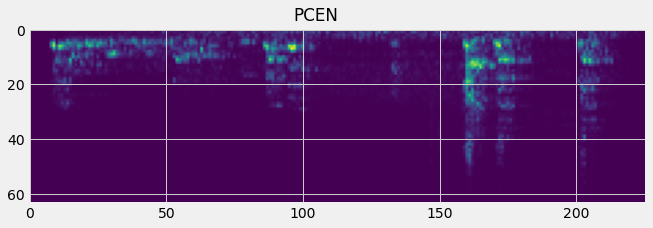

In [ ]:
fig = plt.figure(figsize=(20,3))
fig.suptitle("PCEN")
plt.imshow(PCEN('/content/audio/0006ae4e.wav', 64))

Добавим к нашей таблице 64 коэффициента PCEN:

In [ ]:
n_mels = 64
for n in range(n_mels):
  tag_data.insert(81+n, "pcen_"+str(n), 0)
for i in tqdm(range(len(tag_data.values))):
  for n in range(n_mels): 
    tag_data.loc[i, "pcen_"+str(n)] = np.mean(PCEN('/content/audio/'+tag_data.loc[i, 'fname'], n_mels), axis =1)[n]

100%|██████████| 4970/4970 [1:54:12<00:00,  1.38s/it]


In [ ]:
print(display(tag_data.tail()))

,fname,Bark,Raindrop,Finger_snapping,Run,Whispering,Acoustic_guitar,Strum,Hi-hat,Bass_drum,Crowd,Cheering,Frying_(food),Chewing_and_mastication,Fart,Bass_guitar,Knock,Motorcycle,Stream,Male_singing,Crackle,Sigh,Burping_and_eructation,Female_singing,Tap,Female_speech_and_woman_speaking,Accelerating_and_revving_and_vroom,Clapping,Accordion,Zipper_(clothing),Bus,Meow,Waves_and_surf,Microwave_oven,Child_speech_and_kid_speaking,Buzz,Car_passing_by,Toilet_flush,Purr,Church_bell,...,pcen_25,pcen_26,pcen_27,pcen_28,pcen_29,pcen_30,pcen_31,pcen_32,pcen_33,pcen_34,pcen_35,pcen_36,pcen_37,pcen_38,pcen_39,pcen_40,pcen_41,pcen_42,pcen_43,pcen_44,pcen_45,pcen_46,pcen_47,pcen_48,pcen_49,pcen_50,pcen_51,pcen_52,pcen_53,pcen_54,pcen_55,pcen_56,pcen_57,pcen_58,pcen_59,pcen_60,pcen_61,pcen_62,pcen_63,labels
4965,ffd4ed26.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.036985,0.052634,0.056306,0.062118,0.089476,0.061868,0.053723,0.059153,0.052920,0.064523,0.047592,0.066715,0.059177,0.067404,0.053621,0.063547,0.048213,0.051614,0.047766,0.045242,0.046273,0.038533,0.042822,0.051450,0.049818,0.042638,0.045389,0.051042,0.059426,0.040862,0.035437,0.033950,0.029453,0.024370,0.034999,0.026773,0.020394,0.016118,0.011840,Tick-tock
4966,ffdc411e.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.020107,0.018128,0.018640,0.018476,0.017709,0.017556,0.016666,0.016150,0.015569,0.014339,0.013855,0.013770,0.013001,0.011929,0.011588,0.010545,0.010242,0.009887,0.009004,0.008531,0.007613,0.007180,0.006802,0.006161,0.005517,0.005032,0.004875,0.004309,0.003918,0.003725,0.003514,0.003043,0.002986,0.003063,0.002755,0.002444,0.002190,0.002037,0.001343,Slam
4967,ffe2178b.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0.202711,0.197031,0.178272,0.164050,0.150106,0.150895,0.155660,0.152495,0.140739,0.124706,0.106912,0.099090,0.088254,0.090151,0.087310,0.078827,0.074124,0.068452,0.065001,0.062728,0.056520,0.047926,0.038889,0.034165,0.027824,0.021431,0.015877,0.012249,0.009971,0.009680,0.009698,0.009336,0.008980,0.009023,0.008642,0.011167,0.012502,0.011795,0.005501,Bus
4968,fffa69b7.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.480496,0.532417,0.119821,0.185926,0.178065,0.310327,0.259749,0.292265,0.358388,0.286096,0.078696,0.435359,0.473229,0.020223,0.100860,0.112134,0.117957,0.092680,0.268271,0.170129,0.144120,0.132867,0.087973,0.090374,0.012712,0.014046,0.009117,0.002126,0.000869,0.000665,0.000137,0.000102,0.000027,0.000014,0.000009,0.000008,0.000006,0.000005,0.000005,Electric_guitar
4969,ffff4631.wav,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0.093275,0.090834,0.095255,0.097577,0.100325,0.108957,0.107219,0.108229,0.116683,0.133286,0.164954,0.182621,0.192869,0.189317,0.168036,0.160456,0.151814,0.147225,0.146610,0.139872,0.127928,0.127781,0.135548,0.117059,0.110098,0.116644,0.116736,0.107581,0.097817,0.100741,0.084933,0.067985,0.051111,0.032085,0.027143,0.024872,0.024024,0.022878,0.021176,Meow


None


Сохраним полученную таблицу в файл (извлечем из файла при необходимости):

In [ ]:
tag_data.to_csv("/content/drive/MyDrive/audio_tagging/tag_data64pcen.csv", index=False)

In [ ]:
#tag_data= pd.read_csv("/content/drive/MyDrive/audio_tagging/tag_data_128mels.csv")

Разделим таблицу на признаки и целевые признаки, затем разделим на тренировочную и тестовую выборки.

In [ ]:
features = tag_data.drop(['fname', 'labels'], axis =1)
target = tag_data.drop(['fname', 'labels'], axis=1)
for n in range(n_mels):
  target = target.drop("pcen_"+str(n), axis=1)
print(target.shape)


for n in range(len(tag_list)):
  features = features.drop(tag_list[n], axis =1)
print(features.shape)

(4970, 80)
(4970, 64)


In [ ]:
test_idx = tag_data.sample(frac=0.2, random_state=SEED).index
train_idx = tag_data[~tag_data.index.isin(test_idx)].index

print(len(test_idx), len(train_idx))

994 3976


In [ ]:
features_train, target_train  = features.loc[train_idx], target.loc[train_idx]
features_test, target_test = features.loc[test_idx], target.loc[test_idx]

## Вывод

- Мы импортировали необходимые нам библиотеки, обозначили константы, зафиксировали генератор случайных чисел.

- Мы загрузили таблицу, представляющую из себя список аудио файлов и тэги, которых может быть несколько. Посмотрели, сколько уникальных тегов, создали список уникальных тегов.

- Создали новую таблицу, применим технику One-hot-encoding для тегов.

- Анализ аудио мы будем проводить при помощи PCEN-коэффициентов (per-channel energy normalization - PCEN). Написали функцию для рассчета, посмотрели визуально на график PCEN и добавили к таблице 64 PCEN- коэффициента.

- Сохранили полученную таблицу в файл для возможнсти быстрого извлечения.

- Разделили таблицу на признаки и целевые признаки, затем разделили на тренировочную и тестовую выборки.

# Обучение модели

Обучим модель градиентного бустинга (берем регрессионную модель, т.к. для нее возможен рассчет мультитаргета, как в нашем случае). В качестве функции потерь возьмем MultiRMSE.

In [ ]:
model = CatBoostRegressor(verbose = 100, loss_function='MultiRMSE', random_state = SEED)

In [ ]:
model.fit(features_train,  target_train)

0:	learn: 1.0655401	total: 2.03s	remaining: 33m 50s
100:	learn: 1.0032995	total: 1m 54s	remaining: 17m 2s
200:	learn: 0.9703653	total: 3m 45s	remaining: 14m 57s
300:	learn: 0.9441746	total: 5m 36s	remaining: 13m 2s
400:	learn: 0.9235805	total: 7m 26s	remaining: 11m 7s
500:	learn: 0.9049115	total: 9m 16s	remaining: 9m 14s
600:	learn: 0.8865885	total: 11m 7s	remaining: 7m 23s
700:	learn: 0.8708977	total: 12m 58s	remaining: 5m 31s
800:	learn: 0.8559176	total: 14m 49s	remaining: 3m 40s
900:	learn: 0.8410454	total: 16m 40s	remaining: 1m 49s
999:	learn: 0.8260931	total: 18m 31s	remaining: 0us


Сохраним и при необходимости загрузим из файла модель:

In [ ]:
dump(model, '/content/drive/MyDrive/audio_tagging/model_64pcen.joblib')

['/content/drive/MyDrive/audio_tagging/model_64pcen.joblib']

In [ ]:
#model = load('/content/drive/MyDrive/audio_tagging/model_128mels.joblib')

## Вывод

- Мы обучили модель градиентного бустинга (берем регрессионную модель, т.к. для нее возможен рассчет мультитаргета, как в нашем случае). В качестве функции потерь использовалась MultiRMSE.

- Сохранили модель в файл для возможности быстрой загрузки.

#Тестирование модели

Протестируем модель на тестовой выборке, посмотрим на accuracy и найдем оптимальный порог:

In [ ]:
probs = model.predict(features_test)

best_eval = 0
optimal_thresh =0
for thresh in np.arange(0, 1, 0.01):
  eval = []
  for i in range(target_test.shape[0]):
        
    preds = []
    for n in range(target_test.shape[1]):
      if probs[i][n] >thresh:
        pred = 1
      else:
        pred = 0
      preds.append(pred)
    
    eval.append(eval_metric(target_test.iloc[i], preds, 'Accuracy'))
  
  if np.mean(eval) > best_eval:
    optimal_thresh = thresh
    best_eval = np.mean(eval)
print('test accuracy = {:.4f}'.format(best_eval))
print('optimal_thresh = {}'.format(optimal_thresh))

test accuracy = 0.9870
optimal_thresh = 0.28


Напишем функцию для отображения распознанных тегов:

In [ ]:
def ranking(y, title='', xlabel='', ylabel=''):
    y_pos = np.arange(len(y),0,-1)
    plt.figure(figsize=(5,5))
    cmap = cm.viridis_r
    bar_colors = cmap(y.values)
    plt.barh(y_pos, width=y, height=0.6, left=None, align='center', color=bar_colors, alpha = 0.8)
    plt.yticks(y_pos, y.index)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for p, c, ch in zip(y_pos, y.index, round(y,4)):
        plt.annotate(str(round(ch,4)), xy=(ch if ch>0 else 0, p), va='center')

Попробуем задавать разные пороги (оптимальный и меньше него) и исследовать звуки не из нашей базы.

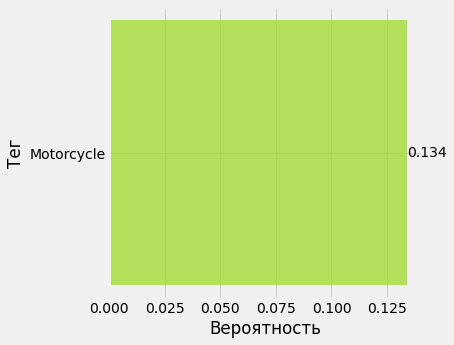

In [ ]:
thresh = 0.1
test_data = pd.DataFrame()

for n in range(n_mels):
  test_data.insert(n, "pcen_"+str(n), 0)

for n in range(n_mels): 
  test_data.loc[0, "pcen_"+str(n)] = np.mean(PCEN('/content/mototsikl-proezjaet-ryadom-mimo-12578.mp3', n_mels), axis =1)[n]

probs = model.predict(test_data)
probs_table = pd.DataFrame({'label_id':tag_list, 'probability': probs[0]}, index = tag_list).sort_values(by = 'probability', ascending = False)
probs_table=probs_table.query('probability > @thresh')
ranking(probs_table['probability'], title='', xlabel='Вероятность', ylabel='Тег')

Правильно, это мотоцикл. Посмотрим как справится со звуком громких оваций:

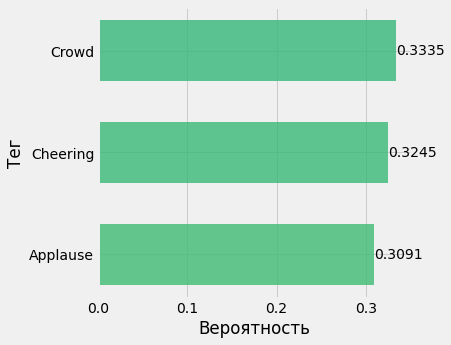

In [ ]:
thresh = optimal_thresh
test_data = pd.DataFrame()

for n in range(n_mels):
  test_data.insert(n, "pcen_"+str(n), 0)

for n in range(n_mels): 
  test_data.loc[0, "pcen_"+str(n)] = np.mean(PCEN('/content/zvuk-radostnyih-ovatsiy-i-applodismentov-19872.mp3', n_mels), axis =1)[n]

probs = model.predict(test_data)
probs_table = pd.DataFrame({'label_id':tag_list, 'probability': probs[0]}, index = tag_list).sort_values(by = 'probability', ascending = False)
probs_table=probs_table.query('probability > @thresh')
ranking(probs_table['probability'], title='', xlabel='Вероятность', ylabel='Тег')

Прекрасно справился с оптимальным порогом. Далее - голос девушки:

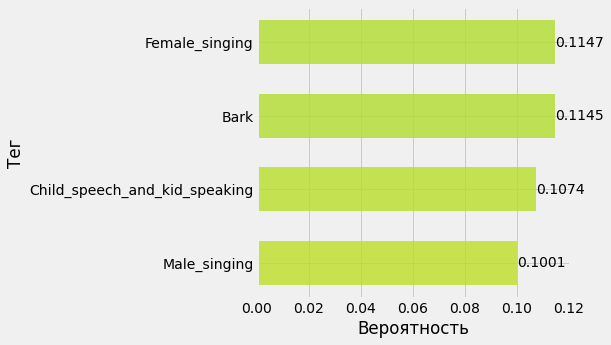

In [ ]:
thresh = 0.1
test_data = pd.DataFrame()

for n in range(n_mels):
  test_data.insert(n, "pcen_"+str(n), 0)

for n in range(n_mels): 
  test_data.loc[0, "pcen_"+str(n)] = np.mean(PCEN('/content/devushka-proiznosit-golosom-kamera-motor-14832.wav', n_mels), axis =1)[n]

probs = model.predict(test_data)
probs_table = pd.DataFrame({'label_id':tag_list, 'probability': probs[0]}, index = tag_list).sort_values(by = 'probability', ascending = False)
probs_table=probs_table.query('probability > @thresh')
ranking(probs_table['probability'], title='', xlabel='Вероятность', ylabel='Тег')

Девушка, конечно, не пела, а говорила. Но в целом "направление мысли" верное. 

## Вывод

- Мы протестировали модель на тестовой выборке, нашли `test accuracy = 0.9870`, 
оптимальный порог `optimal_thresh = 0.28`.

- Мы исследовали звуки других источников. Правильно определили звук мотоцикла, оваций, голос девушки. Но тем не менее значение порога приходилось уменьшать относительно оптимального. 

# Общий вывод

- Мы импортировали необходимые нам библиотеки, обозначили константы, зафиксировали генератор случайных чисел.

- Мы загрузили таблицу, представляющую из себя список аудио файлов и тэги, которых может быть несколько. Посмотрели, сколько уникальных тегов, создали список уникальных тегов.

- Создали новую таблицу, применим технику One-hot-encoding для тегов.

- Анализ аудио мы будем проводить при помощи PCEN-коэффициентов (per-channel energy normalization - PCEN). Написали функцию для рассчета, посмотрели визуально на график PCEN и добавили к таблице 64 PCEN- коэффициента.

- Сохранили полученную таблицу в файл для возможнсти быстрого извлечения.

- Разделили таблицу на признаки и целевые признаки, затем разделили на тренировочную и тестовую выборки.

- Мы обучили модель градиентного бустинга (берем регрессионную модель, т.к. для нее возможен рассчет мультитаргета, как в нашем случае). В качестве функции потерь использовалась MultiRMSE.

- Сохранили модель в файл для возможности быстрой загрузки.

- Мы протестировали модель на тестовой выборке, нашли `test accuracy = 0.9870`, 
оптимальный порог `optimal_thresh = 0.28`.

- Мы исследовали звуки других источников. Правильно определили звук мотоцикла, оваций, голос девушки. Но тем не менее значение порога приходилось уменьшать относительно оптимального. 

- Для улучшения качества распознавания можно использовать аугментацию, расширить тренировочную базу новыми данными. Пересмотреть и объединить схожие категории. 